In [ ]:
from modulos import eda, ann
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

2025-08-07 12:17:21.974374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754583441.985650 3628613 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754583441.989091 3628613 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754583441.999198 3628613 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754583441.999211 3628613 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754583441.999212 3628613 computation_placer.cc:177] computation placer alr

In [3]:
dados = eda.data_processing('Cotas extraidas', '1985-01-01', '2023-12-31', ['dados_diarios_estacao_14280001.csv'])
dados

,14280001
Data,
1985-01-01,1319.0
1985-01-02,1317.0
1985-01-03,1311.0
1985-01-04,1301.0
1985-01-05,1286.0
...,...
2023-12-27,1191.0
2023-12-28,1194.0
2023-12-29,1211.0


### Separação do conjunto

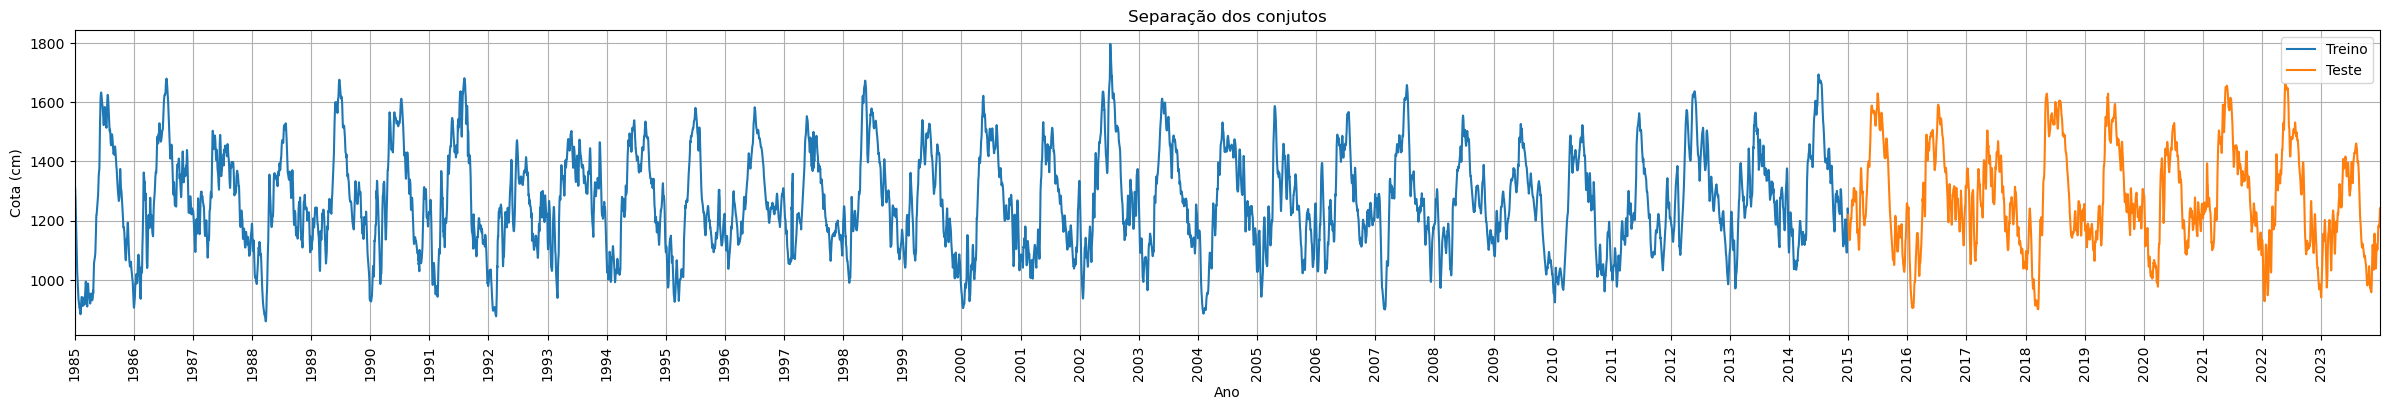

In [4]:
treino = dados[:'2014-12-31']
teste = dados['2015-01-01':]

plt.figure(figsize=(24, 4))
plt.plot(treino)
plt.plot(teste)
plt.legend(['Treino', 'Teste'])
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Ano')
plt.ylabel('Cota (cm)')
plt.xticks(rotation=90)
plt.xlim(dados.index[0], dados.index[-1])
plt.tight_layout()
plt.title('Separação dos conjutos')
plt.show()

In [6]:
def create_multi_step_dataset(series, janela, n_steps):
    X, y = [], []
    for i in range(len(series) - janela - n_steps + 1):
        X.append(series[i:i+janela])
        y.append(series[i+janela:i+janela+n_steps])
    return np.array(X), np.array(y)

In [7]:
janela = 15
steps = 15

X, y = create_multi_step_dataset(dados['14280001'].values, janela, steps)

x_train = X[:treino.shape[0]-janela]
y_train = y[:treino.shape[0]-janela]

x_test = X[treino.shape[0]-janela:]
y_test = y[treino.shape[0]-janela:]

x_scale = MinMaxScaler()
x_train = x_scale.fit_transform(x_train)
x_test = x_scale.transform(x_test)

y_scale = MinMaxScaler()
y_train = y_scale.fit_transform(y_train)

In [8]:
horizonte = [1, 7, 15]

### LSTM

In [9]:
lstm = ann.build_model_lstm(15, janela, steps)

lstm.summary()

I0000 00:00:1754585787.945505 3628613 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10151 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │           240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,260 (4.92 KB)

 Trainable params: 1,260 (4.92 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
lstm.fit(x_train, y_train, epochs=100)

Epoch 1/100


I0000 00:00:1754585789.443317 3629354 cuda_dnn.cc:529] Loaded cuDNN version 90300


342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0832 - mean_absolute_error: 0.2112
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088 - mean_absolute_error: 0.0727
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - mean_absolute_error: 0.0681
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0075 - mean_absolute_error: 0.0659
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0069 - mean_absolute_error: 0.0626
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0065 - mean_absolute_error: 0.0605
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0064 - mean_absolute_error: 0.0596
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - mean_absolute_error: 0.0583
Epoch 9/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0060 - mean_absolute_error: 0.0570
Epoch 10/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0060 - mean_absolute_error: 0.0575
Epoch 11/100
342/342 ━━━━━━━━━━

In [11]:
pred = lstm.predict(x_test)
pred_inv = y_scale.inverse_transform(pred)

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [12]:
r2_score(y_test, pred_inv)

0.8408446857588047

R²: 0.9978


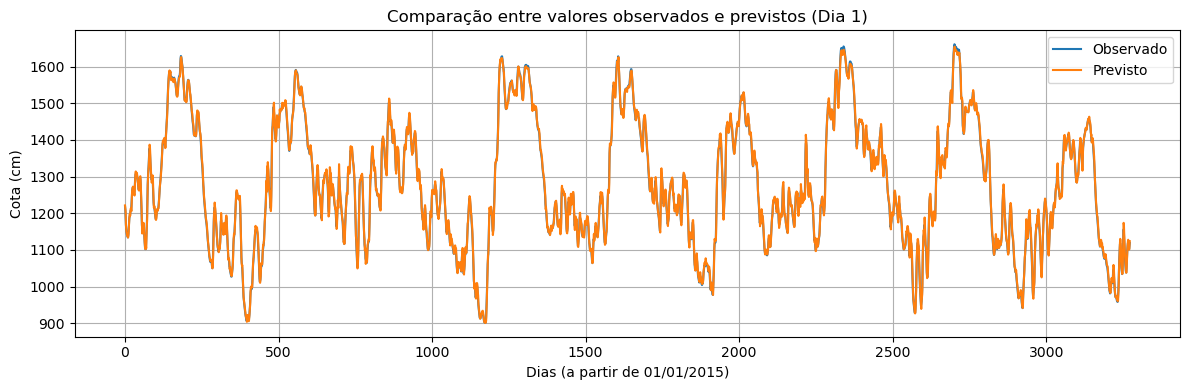

R²: 0.8678


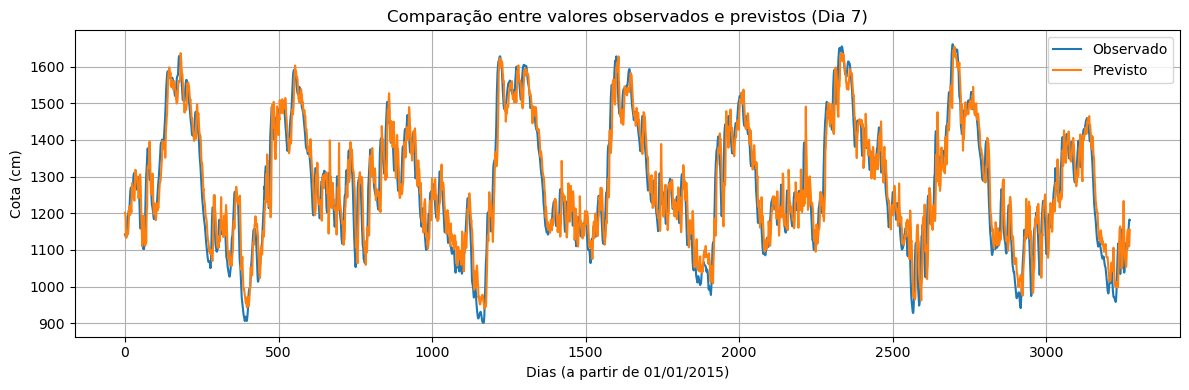

R²: 0.6726


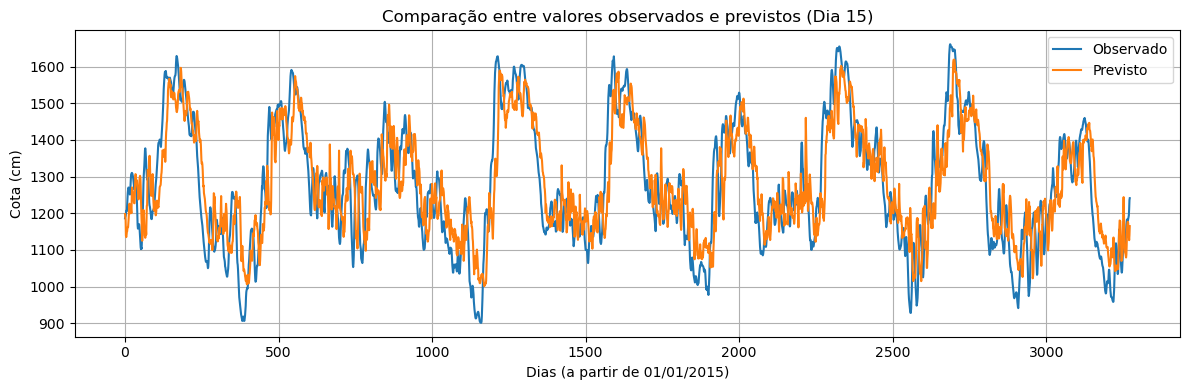

In [13]:
for i in horizonte:
    print(f"R²: {r2_score(y_test[:,i-1], pred_inv[:,i-1]):.4f}")

    plt.figure(figsize=(12, 4))
    plt.plot(y_test[:,i-1], label='Observado')
    plt.plot(pred_inv[:,i-1], label='Previsto')
    plt.xlabel('Dias (a partir de 01/01/2015)')
    plt.ylabel('Cota (cm)')
    plt.title(f'Comparação entre valores observados e previstos (Dia {i})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### MLP

In [15]:
mlp = ann.build_model_mlp((30, 30), janela, steps)

mlp.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 30)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 15)             │           465 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,875 (7.32 KB)

 Trainable params: 1,875 (7.32 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
mlp.fit(x_train, y_train, epochs=100)

Epoch 1/100


I0000 00:00:1754586101.390406 3629348 service.cc:152] XLA service 0x7f304802a4c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754586101.390428 3629348 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2025-08-07 13:01:41.422634: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


101/342 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1481 - mean_absolute_error: 0.3163

I0000 00:00:1754586102.200738 3629348 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0743 - mean_absolute_error: 0.1921
Epoch 2/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 0.0069 - mean_absolute_error: 0.0626
Epoch 3/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0064 - mean_absolute_error: 0.0596
Epoch 4/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - loss: 0.0063 - mean_absolute_error: 0.0593
Epoch 5/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 0.0060 - mean_absolute_error: 0.0574
Epoch 6/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.0059 - mean_absolute_error: 0.0566
Epoch 7/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.0059 - mean_absolute_error: 0.0566
Epoch 8/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0058 - mean_absolute_error: 0.0560
Epoch 9/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.0057 - mean_absolute_error: 0.0553
Epoch 10/100
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0056 - mean_absolute_error: 0.0552  
Epoch 11/100
34

In [17]:
pred2 = mlp.predict(x_test)
pred2_inv = y_scale.inverse_transform(pred2)

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [18]:
r2_score(y_test, pred2_inv)

0.8328195692002193

R²: 0.9938


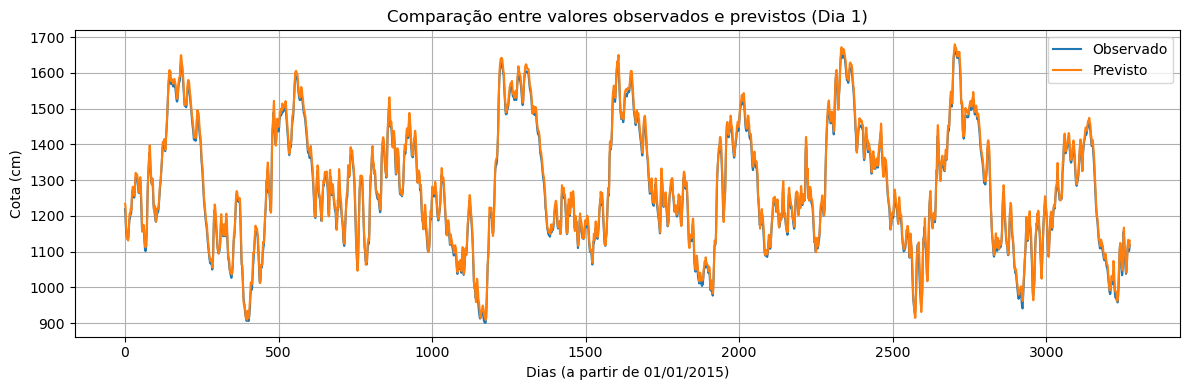

R²: 0.8584


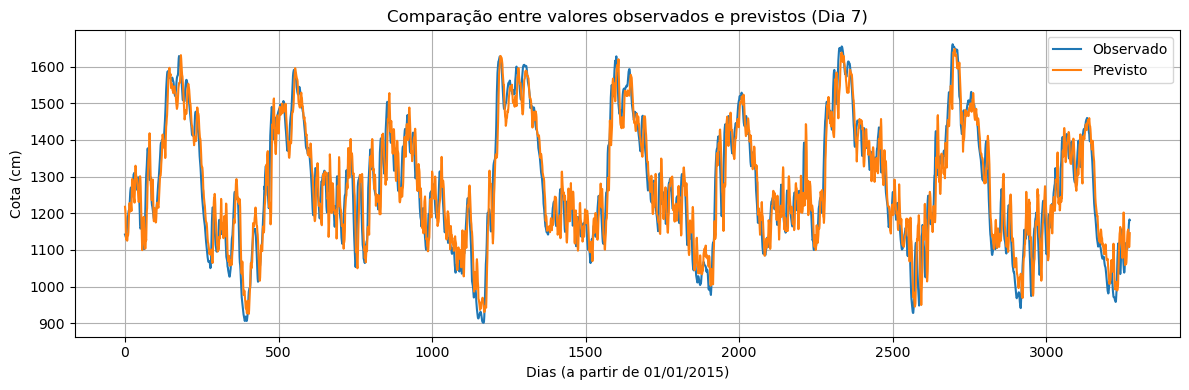

R²: 0.6632


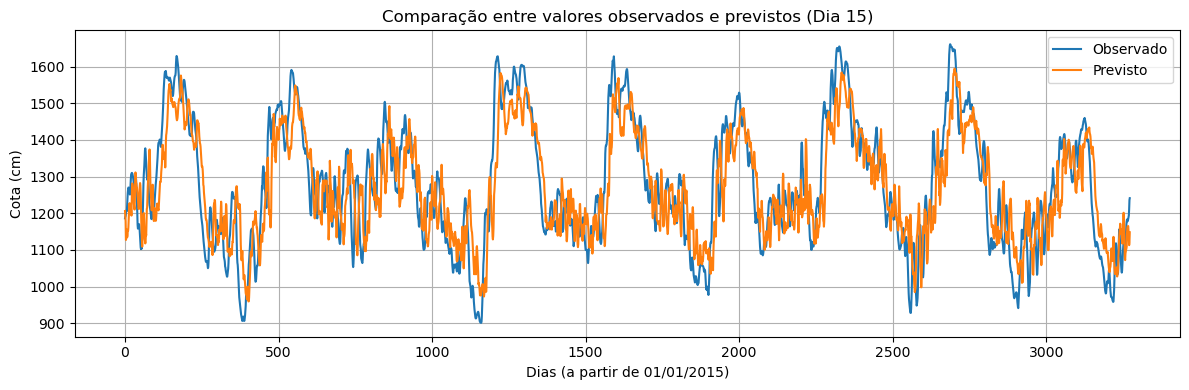

In [19]:
for i in horizonte:
    print(f"R²: {r2_score(y_test[:,i-1], pred2_inv[:,i-1]):.4f}")

    plt.figure(figsize=(12, 4))
    plt.plot(y_test[:,i-1], label='Observado')
    plt.plot(pred2_inv[:,i-1], label='Previsto')
    plt.xlabel('Dias (a partir de 01/01/2015)')
    plt.ylabel('Cota (cm)')
    plt.title(f'Comparação entre valores observados e previstos (Dia {i})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()